# Data Preprocessing

## Setting

## 1) 필요없는 문자 제거

- 정규 표현식을 이용하여 문자 제거

In [ ]:
# 시도해봤던 정규 표현식

# temp = re.sub('[ㄱ-하-ㅣ]', '', text)     # 모든 한글 자음,모음 제거
# temp = re.sub('[^\w\s]', '', text)        # 단어 문자('\w')와 공백 문자('\s')를 제외한 모든 문자 제거
# temp = re.sub('[ㄱ-ㅎ()]', '',text)       # 한글 자음과 괄호'()' 제거
# temp = re.sub('[\n]', '', text)           # 개행문자('\n') 제거
# temp = re.sub(r"\n", '', text)            # 개행문자('\n') 제거
# temp = re.sub('[^,.?!\w\s]', '', text)    # 단어 문자('\w'), 공백 문자('\s'), 쉼표(','), 마침표('.'), 물음표('?'), 느낌표('!')를 제외한 모든 문자를 제거

In [ ]:
import pandas as pd
import re

In [ ]:
def text_preprocessing(df_reviews):
    """Review_Text의 리뷰글을 전처리 하는 함수"""
    for i in range(len(df_reviews)):
        text = df_reviews['Review_Text'][i]
    
        if not isinstance(text, str):
            text = str(text)
        temp = re.sub('[^가-힣a-zA-Z0-9\s]', '',text)

        df_reviews.loc[[i],['Review_Text']] = temp
        
    df_reviews['Review_Text'] = df_reviews['Review_Text'].str.replace('\n','')
    df_reviews.drop(df_reviews[df_reviews['Review_Text'] == 'nan'].index, inplace=True)
    df_reviews.drop(df_reviews[df_reviews['Review_Text'] == ''].index, inplace=True)
    df_reviews.to_csv('./S_hotel_buffet_review_data_preprocess.csv', index = False, encoding="utf-8")
    
    return df_reviews

## 2) Pyhanspell(맞춤법 검사기)

- Pyhanspell 사용하기 전 준비사항
    1. 네이버에 `네이버 맞춤법 검사기` 치기  
    2. 개발자 도구를 열고 맨위 항목 `Network`를 들어간다.  
    3. 페이지 새로고침을 한 뒤 네이버 맞춤법 검사기의 검사하기 버튼을 누른다.  
    4. Network항목 안 목록에 `SpellerProxy?passportKey=...`를 누른다.  
    5. Headers항목에 뜨는 `Request URL`을 드래그하여 복사한다.  
    6. requestURL 변수를 하나 만들어 거기다가 저장해준다.  

In [2]:
from hanspell import spell_checker
requestURL = "https://m.search.naver.com/p/csearch/ocontent/util/SpellerProxy?passportKey=d57c1916c869a49c5e8e10440ab2fd7bb04130e2&_callback=jQuery112408200366766849903_1721113439875&q=%EB%A7%9E%EC%B6%A4%EB%B2%95+%EA%B2%80%EC%82%AC%EB%A5%BC+%EC%9B%90%ED%95%98%EB%8A%94+%EB%8B%A8%EC%96%B4%EB%82%98+%EB%AC%B8%EC%9E%A5%EC%9D%84+%EC%9E%85%EB%A0%A5%ED%95%B4+%EC%A3%BC%EC%84%B8%EC%9A%94.&where=nexearch&color_blindness=0&_=1721113439876"

In [ ]:
def ReviewSpellChecker(df_reviews):
    """Review_Text의 맞춤법 고치는 함수"""
    for i in range(len(df_reviews)):
        sentence = df_reviews['Review_Text'][i]
        if len(sentence) > 0:
            result = spell_checker.check(df_reviews['Review_Text'][i], requestURL).checked
        else:
            result = ""
        df_reviews.loc[i, 'Review_Text'] = result
        
    df_reviews.to_csv('./S_hotel_buffet_review_spellchecker.csv', index = False, encoding="utf-8")
    return df_reviews

## 3) Spacing(띄어쓰기 교정)

- 띄어쓰기 교정 패키지로 Pykospacing을 사용했다.
- 교정이후 한 글자만 띄어쓰기된 부분이 보인다.

In [3]:
from pykospacing import Spacing
spacing = Spacing()

In [ ]:
def checkSpacing(df_reviews):
    """띄어쓰기 교정하는 함수"""
    for i in range(len(df_reviews)):
        print(i, df_reviews["Review_Text"][i])
        test_space = spacing(df_reviews["Review_Text"][i])
        # temp_reviews['Review_Text'][i] = test_space
        df_reviews.loc[i, 'Review_Text'] = test_space

## 4) 길이 탐색(이상치 제거)

### 리뷰글의 길이 확인
- 시각적 자료 Boxplot과 Histogram을 사용하여 확인한다.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
temp_reviews_spacing = pd.read_csv("C:\\Users\\pps\\Desktop\\Restaurant_Review\\Review_Analyzer\\Data_Preprocessing\\S_hotel_buffet_review_spacingcheck.csv", index_col=0)

# 리뷰 길이 구하기
temp_reviews_spacing["review_length"] = temp_reviews_spacing["Review_Text"].str.len()


In [18]:
# 한글 글꼴 설정

font_path = 'C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf'
font_name = plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name

In [19]:
temp_reviews_spacing["review_length"].describe()

count    185.000000
mean      72.848649
std       90.498792
min        1.000000
25%       13.000000
50%       40.000000
75%      102.000000
max      430.000000
Name: review_length, dtype: float64

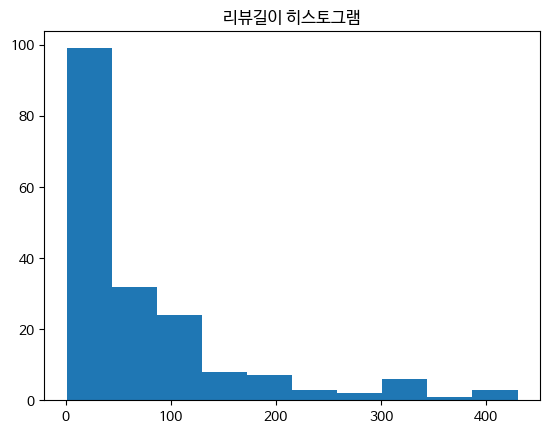

In [20]:
# Histogram
plt.hist(temp_reviews_spacing["review_length"], bins = 10)
# plt.hist(temp_reviews_spacing["review_length"], bins=30)
plt.title("리뷰길이 히스토그램")
plt.show()

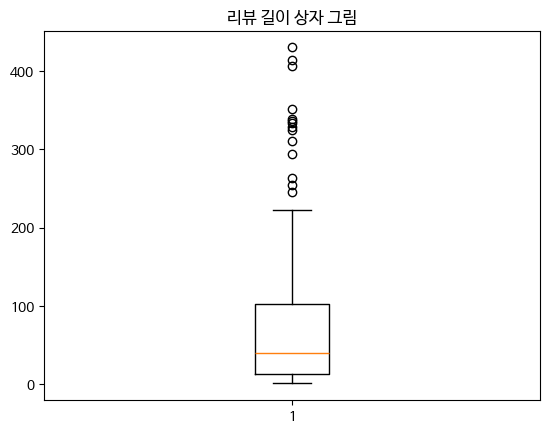

In [21]:
# Box Plot
plt.boxplot(temp_reviews_spacing["review_length"])
plt.title("리뷰 길이 상자 그림")
plt.show()

### 이상치 확인및 제거

- IQR방법을 이용하여 이상치를 찾았다.  
    - IQR (Inter-Quartile Range)  
    - IQR = Q3(3사분위수) - Q1(1사분위수)  
    - 제거기준 = (Q3 + IQR * 1.5보다 큰 값) &(Q1 - IQR * 1.5보다 작은 값)  

In [ ]:
def find_IQR(df_length_reviews,df_reviews):
    """IQR방식을 이용한 이상치를 찾아 제거하는 함수"""
    new_df_length = df_length_reviews.copy()
    new_df_reviews = df_reviews.copy()
    Q1 = new_df_length["리뷰 길이"].quantile(q=0.25)
    Q3 = new_df_length["리뷰 길이"].quantile(q=0.75)
    IQR = Q3 - Q1
    IQR_df = new_df_length[(new_df_length["리뷰 길이"] >= Q3 + 1.5 * IQR) | (new_df_length["리뷰 길이"] <= Q1 - 1.5*IQR)].index
    
    new_df_reviews = new_df_reviews.drop('Unnamed: 0.1', axis = 1)
    new_df_reviews = new_df_reviews.drop('Unnamed: 0', axis = 1)
    
    new_df_reviews.drop(IQR_df, inplace = True)
    new_df_reviews.reset_index(drop=True, inplace = True)
    
    new_df_reviews.to_csv("./S_hotel_buffet_review_IQR.csv")
    return new_df_reviews

## 5) 불용어/ 신조어 처리

- 불용어는 리뷰글 분석에 영향을 끼친다고 생각하기에 불용어 처리를 하지 않겠다.  
- 신조어는 리뷰글에서 많이 보일 수 없기 때문에 신조어 처리를 하지 않도록 하겠다.  
    - 분석을 통해 처리가 필요하다면 전처리 과정으로 돌아와 처리하는 것으로 계획한다.